<a href="https://colab.research.google.com/github/BLayus/Acidentes_Transito_UK/blob/main/UK_Roads_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**UK Roads Novo Notebook**

##**Importando Datasets e Bibliotecas**

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime

In [3]:
# Aqui conectamos o MEU google drive (onde estão os arquivos na pasta UK Roads Accidents) com o Collab para que possa ler ele!
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# LEIA SEUS DADOS AQUI
UK_accidents = pd.read_csv('/content/drive/MyDrive/Data Science /UK Road Accidents/dft-road-casualty-statistics-accident-2020.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
# LEIA OS DADOS DA SEGUNDA TABELA AQUI
UK_casualty = pd.read_csv('/content/drive/MyDrive/Data Science /UK Road Accidents/dft-road-casualty-statistics-casualty-2020.csv')

In [6]:
# LEIA OS DADOS DA TERCEIRA TABELA AQUI
UK_vehicles = pd.read_csv('/content/drive/MyDrive/Data Science /UK Road Accidents/dft-road-casualty-statistics-vehicle-2020.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


###**Tratamento Inicial dos Dados**

In [7]:
#APLICAÇÃO DO MERGE ENTRE df_accidents, df_casualty e df_vehicles

UK_merge = pd.merge(pd.merge(UK_accidents, UK_casualty, on='accident_index'), UK_vehicles, on='accident_index')

In [8]:
#DELETAR AS COLUNAS DUPLICADAS

UK_merge.drop(['accident_reference_x', 'accident_year_y',
'accident_reference_y', 'vehicle_reference_x', 'vehicle_reference_y'],
axis=1, inplace=True)

In [9]:
# DELETAR OUTRAS COLUNAS DESNECESSÁRIAS PARA ESTA ANÁLISE
UK_merge.drop(['accident_year', 'accident_reference', 'accident_index', 'first_road_number', 'second_road_number',
          'casualty_home_area_type', 'casualty_imd_decile'], axis=1, inplace=True)

In [10]:
#DELETAR COLUNAS RELATIVAS À TABELA DE VEÍCULOS

UK_merge.drop(['vehicle_direction_from', 'vehicle_direction_to', 'age_band_of_driver', 'generic_make_model', 'driver_imd_decile', 'driver_home_area_type', 
         'engine_capacity_cc', 'propulsion_code'], axis=1, inplace=True)

##**Feature Engineering**

In [11]:
# CLASSIFICAR OS ACIDENTES EM NÍVEIS DE GRAVIDADE, 
#DE ACORDO COM O TIPO DE ACIDENTE E O NÚMERO DE VÍTIMAS
# Colocar em uma nova coluna se o acidente foi grave = 1, ou se outro tipo = 0

UK_merge['major_incident'] = [1 if (a==1)&(b>=3) else 0 \
                               for a, b in zip(UK_merge['accident_severity'], \
                                               UK_merge['number_of_casualties'])]

In [12]:
# Converter data e horário para formato timestamp

UK_merge['time_stamp'] = UK_merge['date'] + ' ' + UK_merge['time']

UK_merge['time_stamp'] = pd.to_datetime(UK_merge['time_stamp'], format='%d/%m/%Y %H:%M')

In [13]:
# Criando novas colunas para mês e Hora do dia

UK_merge['month'] = UK_merge['time_stamp'].dt.month

UK_merge['hour'] = UK_merge['time_stamp'].dt.hour

In [14]:
# Substituir valores para nomes dos dias da semana
UK_merge['day_of_week'].replace({1:'Sun', 2:'Mon', 3:'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'}, inplace=True)

In [15]:
# Criar dois subgrupos separados

incidentes_graves = UK_merge[UK_merge['major_incident']==1]
incidentes_outros = UK_merge[UK_merge['major_incident']==0]

In [16]:
# Neste outro exemplo, podemos agrupar 1, 2, 3 e mais do que 4 vítimas
# Substituir todos os valores maiores que 4 por um grupo chamado 4
# Fiz de um jeito bem artesanal...

other_casualty_group = UK_accidents['number_of_casualties'] >= 4

UK_accidents['number_of_casualties'].replace([5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 19, 41], 4, inplace=True)

In [17]:
# Vou fazer para outra coluna: road type
# legenda para esta categoria:
#1: Roundabout
#2: One way street
#3: Dual carriageway
#6: Single carriageway
#7: Slip road

sorted(UK_accidents['road_type'].unique())

[1, 2, 3, 6, 7, 9]

In [18]:
# Neste caso vou trocar o "9" por NaN

UK_accidents['road_type'] = UK_accidents['road_type'].replace(9,np.NaN)

In [19]:
# Temos neste dataset 3 tipos de anotação nula: -1, 9 e 99
# Vou substituir todos os 9 por NaN de cada uma das colunas

UK_accidents['weather_conditions'] = UK_accidents['weather_conditions'].replace(9,np.NaN)
UK_accidents['road_surface_conditions'] = UK_accidents['road_surface_conditions'].replace(9,np.NaN)
UK_accidents['special_conditions_at_site'] = UK_accidents['special_conditions_at_site'].replace(9,np.NaN)
UK_accidents['carriageway_hazards'] = UK_accidents['carriageway_hazards'].replace(9,np.NaN)

# Vou substituir todos os 99 por NaN em cada uma das colunas

UK_accidents['speed_limit'] = UK_accidents['speed_limit'].replace(99,np.NaN)
UK_accidents['junction_detail'] = UK_accidents['junction_detail'].replace(99,np.NaN)

# Vou substituir todos os -1 por NaN em todo dataset

UK_accidents = UK_accidents.replace(-1,np.NaN)

In [20]:
# Remover os dados nulos do dataset

UK_accidents = UK_accidents.dropna()

##**Análise Estatística Preliminar**

In [21]:
# Utilizando o describe para ter um panorama de como estão os dados
UK_merge.describe()

,accident_year_x,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,local_authority_district,...,hit_object_off_carriageway,first_point_of_impact,vehicle_left_hand_drive,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_of_vehicle,major_incident,month,hour
count,177024.0,176990.000000,1.769900e+05,176990.000000,176990.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,...,177024.00000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000,177024.000000
mean,2020.0,443298.820080,2.846181e+05,-1.374337,52.449868,31.966626,2.741013,2.211508,1.804535,367.344592,...,1.76423,1.776979,1.084090,4.700018,1.436037,36.197662,6.264213,0.009558,6.737222,13.822504
std,0.0,93396.469702,1.405061e+05,1.360752,1.266750,20.431601,0.484563,0.944919,1.391881,212.686098,...,11.13887,1.272952,0.787315,1.881886,0.636411,20.375395,6.362199,0.097297,3.659439,4.886606
min,2020.0,71500.000000,1.271500e+04,-7.412812,49.970479,1.000000,1.000000,1.000000,1.000000,-1.000000,...,-1.00000,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-1.000000,0.000000,1.000000,0.000000
25%,2020.0,384230.000000,1.723870e+05,-2.237164,51.437793,14.000000,3.000000,2.000000,1.000000,204.000000,...,0.00000,1.000000,1.000000,5.000000,1.000000,23.000000,0.000000,0.000000,3.000000,10.000000
50%,2020.0,440522.000000,2.763700e+05,-1.397193,52.377645,34.000000,3.000000,2.000000,1.000000,363.000000,...,0.00000,1.000000,1.000000,6.000000,1.000000,35.000000,5.000000,0.000000,7.000000,14.000000
75%,2020.0,514719.000000,3.912900e+05,-0.327997,53.416408,46.000000,3.000000,2.000000,2.000000,531.000000,...,0.00000,3.000000,1.000000,6.000000,2.000000,51.000000,11.000000,0.000000,10.000000,17.000000
max,2020.0,655138.000000,1.184351e+06,1.756257,60.541144,99.000000,3.000000,13.000000,41.000000,941.000000,...,99.00000,9.000000,9.000000,6.000000,3.000000,100.000000,96.000000,1.000000,12.000000,23.000000


In [22]:
# O describe não demonstra muita coisa, pois as colunas são, em sua maioria,
# dados categóricos codificados através de números, por exemplo:
# Accident severity é codificado como 1, 2 e 3, sendo 1 mais severo e 3 menos severo

sorted(UK_merge['accident_severity'].unique())

[1, 2, 3]

accident_severity,Frequência,Porcentagem
3,134973,76.245594
2,38255,21.610064
1,3796,2.144342


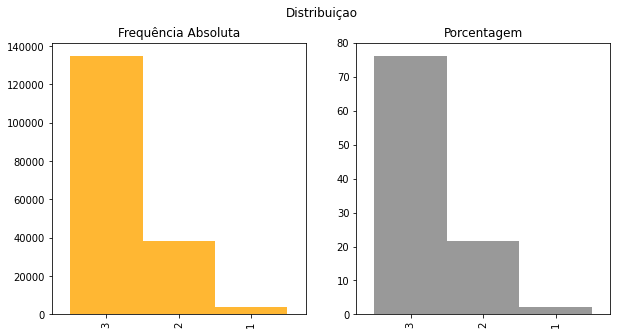

In [23]:
# Para entender estes dados categóricos, é preciso agregá-los em somas e percentuais, 
# daí conseguiremos pereber a distribução entre as categorias

frequencia = UK_merge['accident_severity'].value_counts()
percentual = UK_merge['accident_severity'].value_counts(normalize=True) * 100

freq_accident = pd.DataFrame({'Frequência': frequencia, 'Porcentagem': percentual})
freq_accident.rename_axis('accident_severity', axis='columns', inplace=True)

fig, axes = plt.subplots(1,2, figsize=(10,5))
fig. suptitle('Distribuiçao')
axes[0].set_title('Frequência Absoluta')
axes[1].set_title('Porcentagem')
freq_accident['Frequência'].plot.bar(width=1, alpha=0.8, color='orange', ax=axes[0])
freq_accident['Porcentagem'].plot.bar(width=1, alpha=0.8, color='gray', ax=axes[1])
plt.show

freq_accident

###**Visualizando Frequência em Números Absolutos e Percentuais**

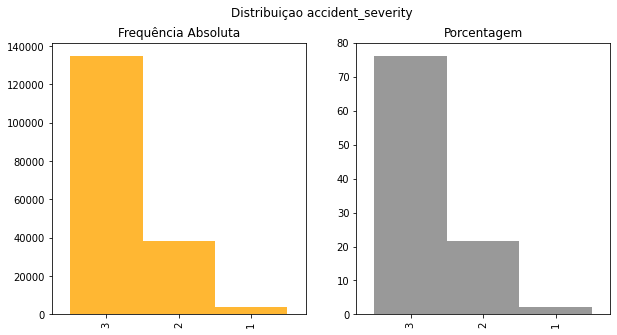

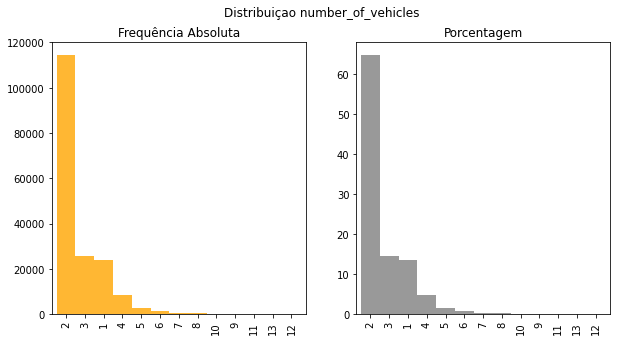

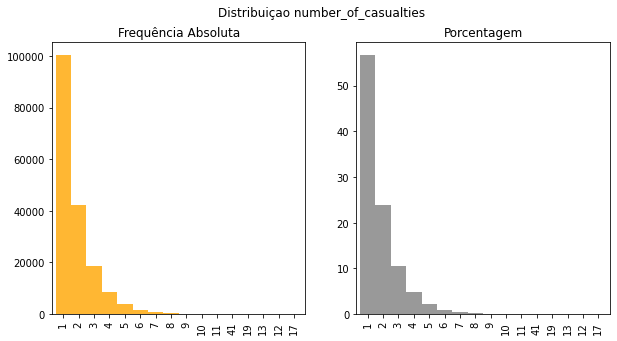

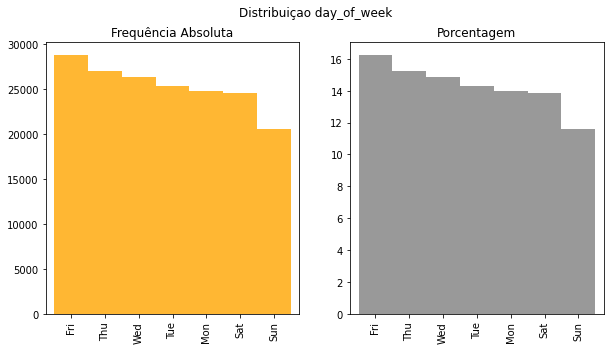

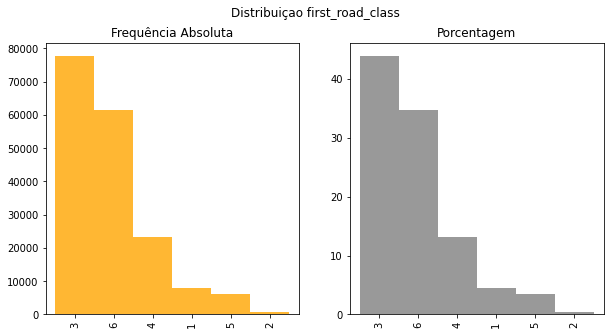

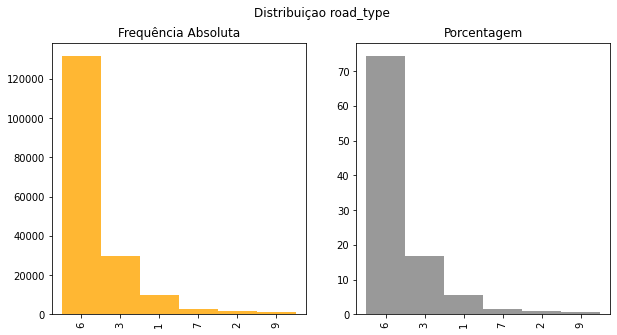

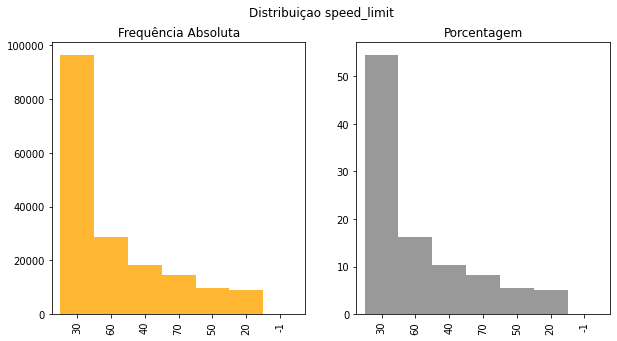

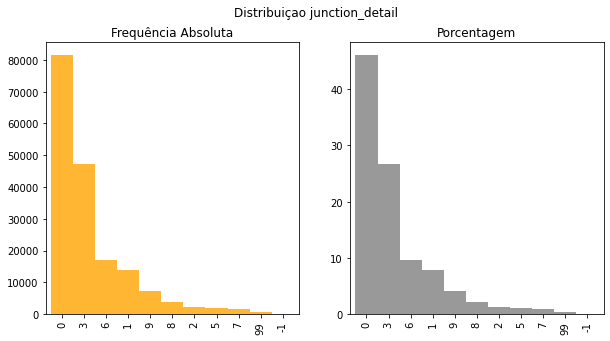

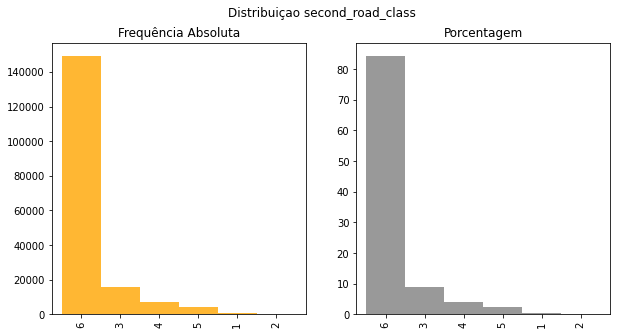

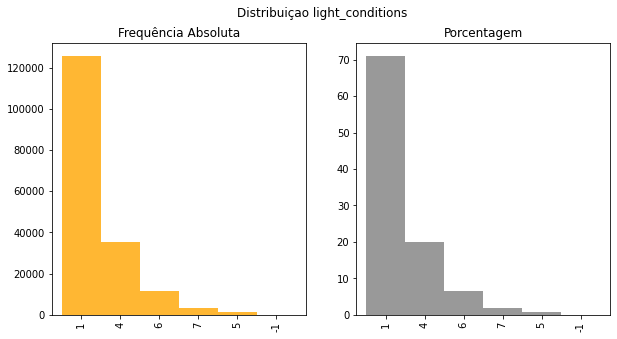

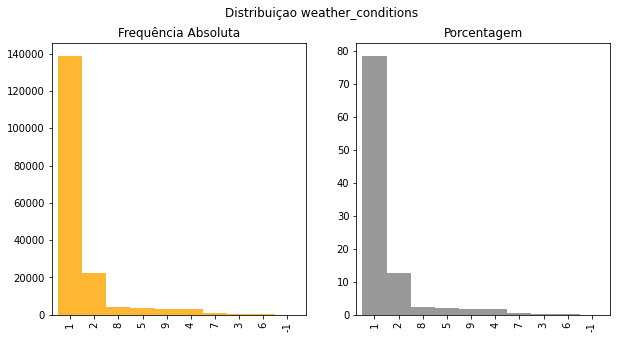

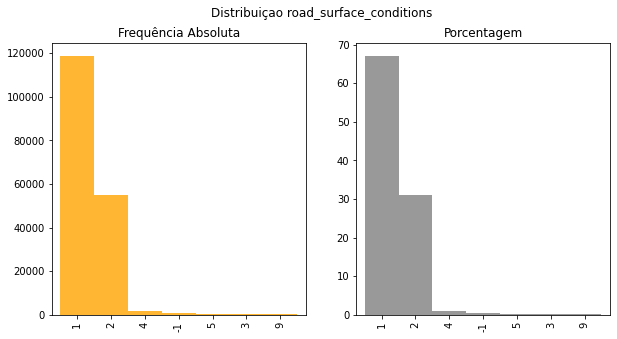

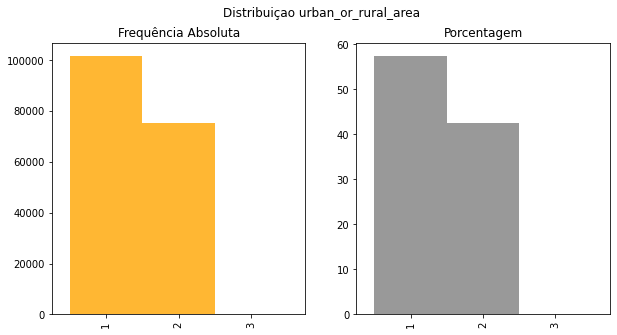

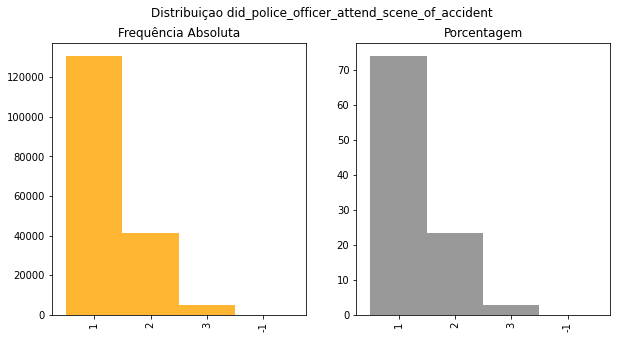

In [24]:
# Vou fazer esta leitura para cada uma das variáveis categóricas através de um FOR

categorical = ['accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'first_road_class', 'road_type', 'speed_limit', 'junction_detail',
       'second_road_class', 'light_conditions', 'weather_conditions', 'road_surface_conditions',
        'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident']


for x in categorical:
    frequencia = UK_merge[x].value_counts()
    percentual = UK_merge[x].value_counts(normalize=True) * 100

    freq_accident = pd.DataFrame({'Frequência': frequencia, 'Porcentagem': percentual})
    
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    fig. suptitle('Distribuiçao'+' '+ x)
    axes[0].set_title('Frequência Absoluta')
    axes[1].set_title('Porcentagem')
    freq_accident['Frequência'].plot.bar(width=1, alpha=0.8, color='orange', ax=axes[0])
    freq_accident['Porcentagem'].plot.bar(width=1, alpha=0.8, color='gray', ax=axes[1])
    plt.show

###**Observações Sobre a Primeira Análise**

1 - A grande maioria dos acidentes são do tipo 3 (leve), atingindo quase 80% dos registros, já os acidentes do tipo1 (graves) somam pouco mais de 1%, o restante, quase 20%, são do tipo 2 (intermediário)

2 - Aproximadamente 60% dos acidentes são entre dois veículos apenas e aproximadamente 30% são acidentes com veículos sozinhos (apenas 1 veículo).

3 - Aproximadamente 80% dos acidentes envolve apenas uma vítima e aprox. 10% envolve 2 vítimas

4 - A maioria dos acidentes (16%), ocorre na sexta feira

5 - Quase 60% dos acidentes acontece em áreas com limite de velocidade de até 30MPH (50Kmh), seguido por áreas com velocidade até 60MPH (100Kmh), com pouco mais de 10%.

6 - 40% dos casos acontecem em trechos sem junção em até 20m, ou seja, trechos em linha reta, seguido por colisões em junções em T, com pouco menos de 30%.

7 - 70% dos casos ocorrem em cndições de luz do dia, seguido por 20% que ocorrem em condições de noite com iluminação urbana acesa.

8 - 70% dos acidentes acontecem com pista seca e aprox. 20% acontecem em pista molhada.

9 - Distribuição 70% a 30% entre Áreas Urbanas e Rurais.

10 - 70% dos casos foram atendidos por um policial ou autoridade de trânsito.

In [25]:
# Cruzando colunas para avaliar por exemplo, quantidade de acidentes por severidade
# em função do limite de velocidade

pd.crosstab(UK_merge['accident_severity'], UK_merge['speed_limit'], normalize=True) * 100

# 45% dos acidentes leves acontecem em áreas até 30mph
# 8% dos acidentes leves acontecem em áreas com velocidade superior a 60mph

speed_limit,-1,20,30,40,50,60,70
accident_severity,,,,,,,
1,0.000000,0.036153,0.540040,0.239516,0.168339,0.855816,0.304478
2,0.001130,0.890275,10.282787,2.351659,1.363092,4.849625,1.871498
3,0.005084,4.175705,43.580531,7.841875,3.998893,10.589525,6.053981


In [26]:
# Cruzando colunas para avaliar por exemplo, quantidade de vítimas 
# em função do limite de velocidade

pd.crosstab(UK_merge['number_of_casualties'], UK_merge['speed_limit'], normalize=True) * 100

# 50% dos casos acontecem em áreas até 30 mph e envolvem apenas uma vítima

speed_limit,-1,20,30,40,50,60,70
number_of_casualties,,,,,,,
1,0.006214,3.890433,34.743877,5.245052,2.364651,7.178688,3.212559
2,0.000000,0.764868,11.640230,2.806399,1.593004,4.832113,2.295734
3,0.000000,0.269455,4.533284,1.345580,0.833785,2.274268,1.323549
4,0.000000,0.081345,2.062997,0.576193,0.427061,1.028109,0.648500
5,0.000000,0.045192,0.901008,0.228783,0.141224,0.443443,0.367182
6,0.000000,0.000000,0.325380,0.128796,0.057619,0.257592,0.206752
7,0.000000,0.039543,0.079085,0.055360,0.007909,0.162125,0.130491
8,0.000000,0.000000,0.036153,0.027115,0.036153,0.040672,0.045192
9,0.000000,0.000000,0.045757,0.010168,0.020336,0.000000,0.000000


In [27]:
# Vou trazer um cruzamento entre a severidade do acidente e a localização, se rural ou urbana

pd.crosstab(UK_merge['accident_severity'], UK_merge['urban_or_rural_area'], normalize=True) * 100

# Nas áreas rurais, 23% dos acidentes são leves e só 1% é grave, nas áreas urbanas, 55% são leves e só 0,5% é grave

urban_or_rural_area,1,2,3
accident_severity,,,
1,0.614606,1.529736,0.000000
2,10.640930,10.966875,0.002260
3,46.216332,30.012315,0.016947


##**Revisão da Análise Preliminar**

Dividir o dataset em dois grandes grupos: graves e leves/moderados
Como o dataset inclui muitos registros e a diferença entre os casos de acidentes leves e graves é muito grande, vou dividir em dois grupos e refazer a análise pra ver se há diferença de interpretação.
Não desejo perder os dados, portanto vou juntar acidentes leves e moderados em um grupo e acidentes graves em outro grupo, depois vou reaplicar o for para ver os gráficos novamente.

In [28]:
# Criar os dois datasets separadamente

UK_incident_major = pd.DataFrame(UK_merge[UK_merge['major_incident']==1])
UK_incident_other = pd.DataFrame(UK_merge[UK_merge['major_incident']==0])

###**Distribuição dos Acidentes Graves**

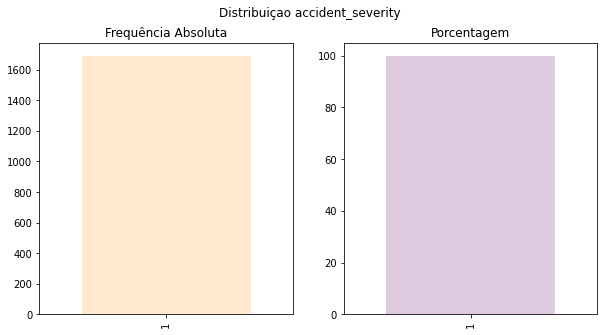

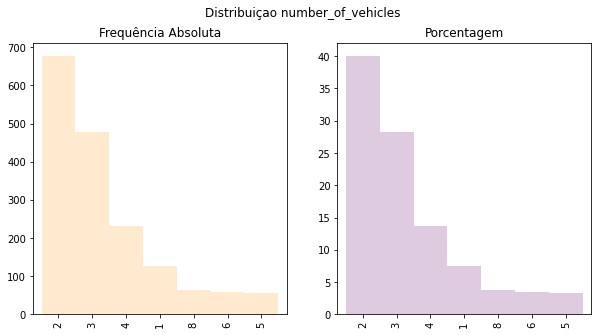

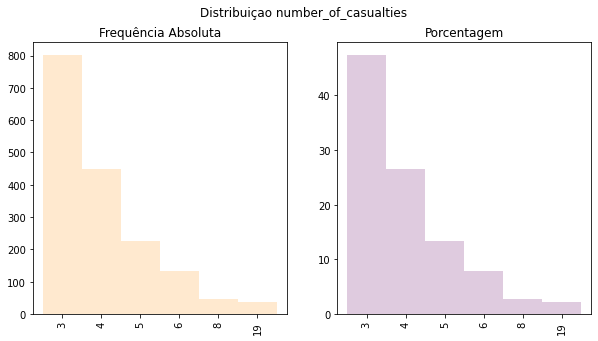

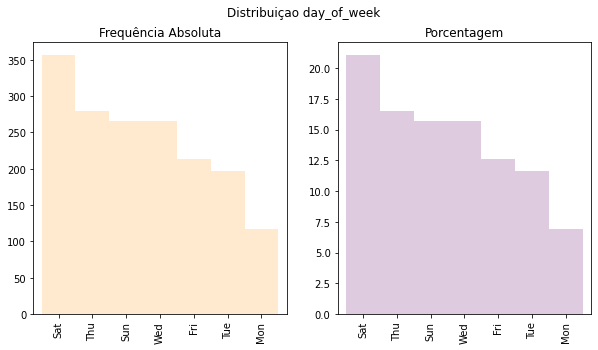

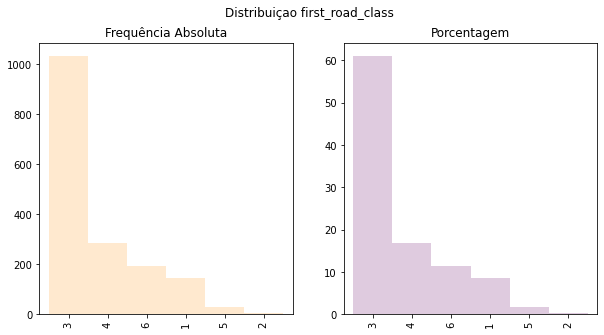

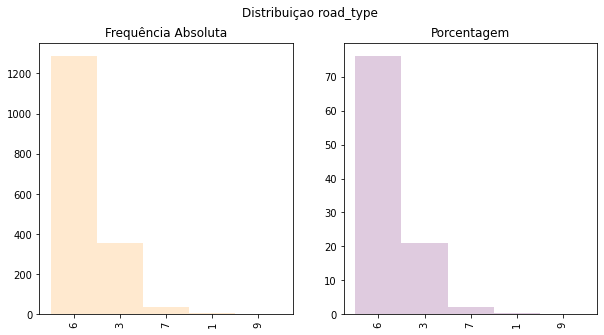

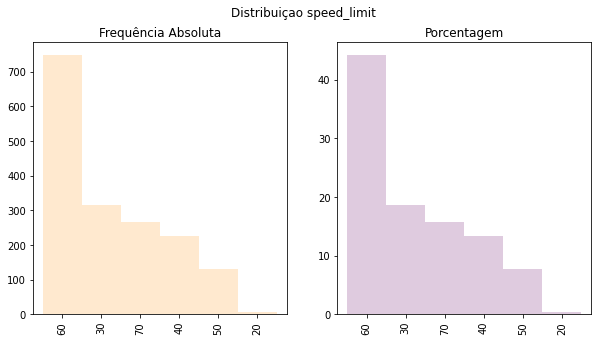

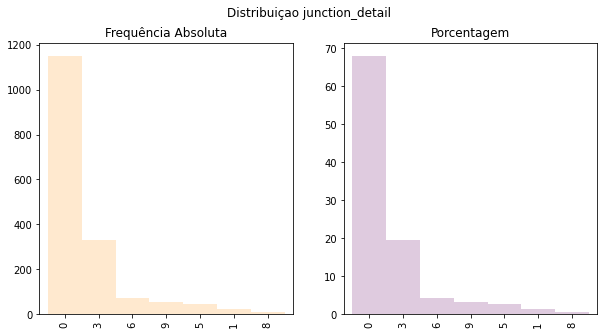

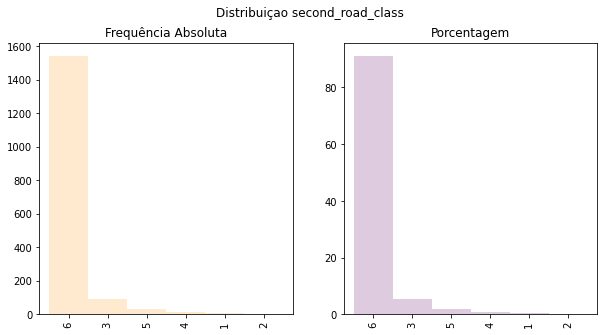

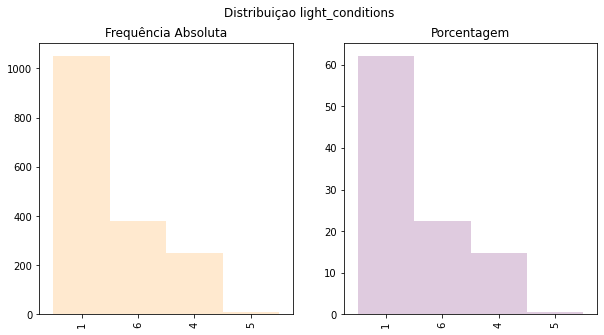

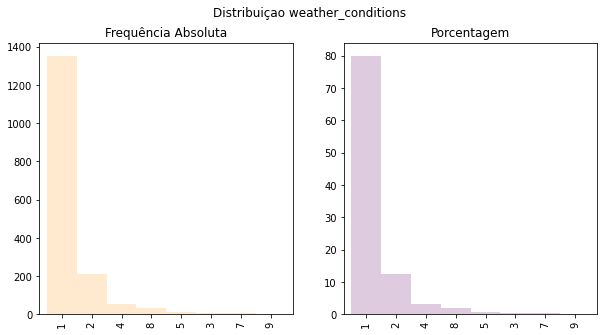

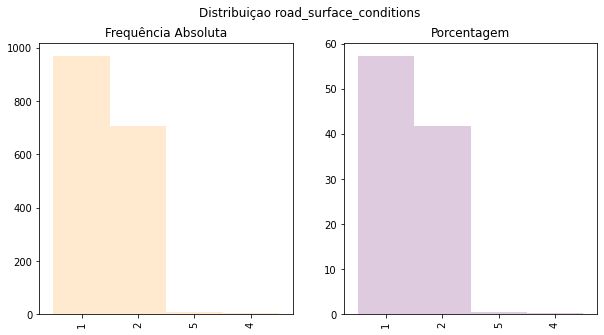

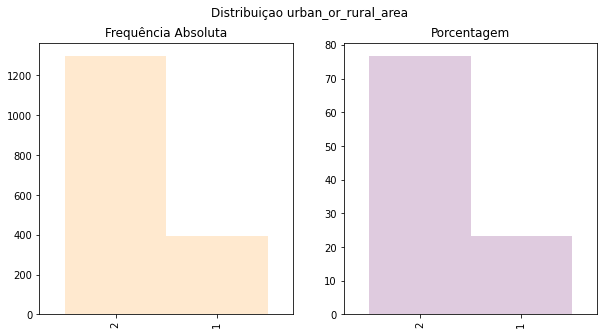

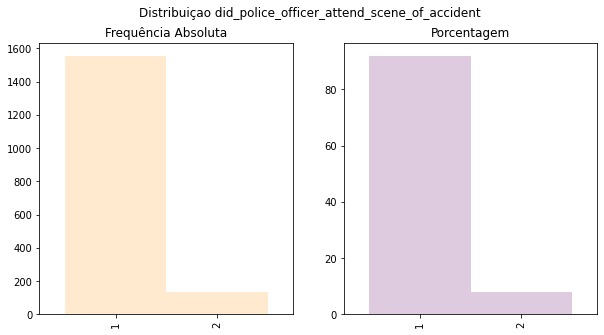

In [29]:
# Repetindo o for para plotar os gráficos dos Incident_major
# as colunas são as mesmas...

categorical = ['accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'first_road_class', 'road_type', 'speed_limit', 'junction_detail',
       'second_road_class', 'light_conditions', 'weather_conditions', 'road_surface_conditions',
        'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident']

for x in categorical:
    frequencia = UK_incident_major[x].value_counts()
    percentual = UK_incident_major[x].value_counts(normalize=True) * 100

    freq_accident = pd.DataFrame({'Frequência': frequencia, 'Porcentagem': percentual})
    
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    fig. suptitle('Distribuiçao'+' '+ x)
    axes[0].set_title('Frequência Absoluta')
    axes[1].set_title('Porcentagem')
    freq_accident['Frequência'].plot.bar(width=1, alpha=0.8, color='bisque', ax=axes[0])
    freq_accident['Porcentagem'].plot.bar(width=1, alpha=0.8, color='thistle', ax=axes[1])
    plt.show

###**Distribuição dos Acidentes Other**

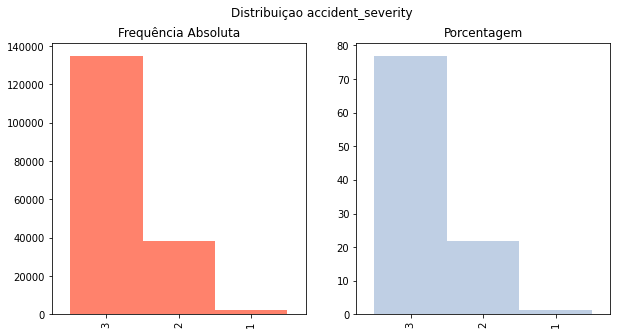

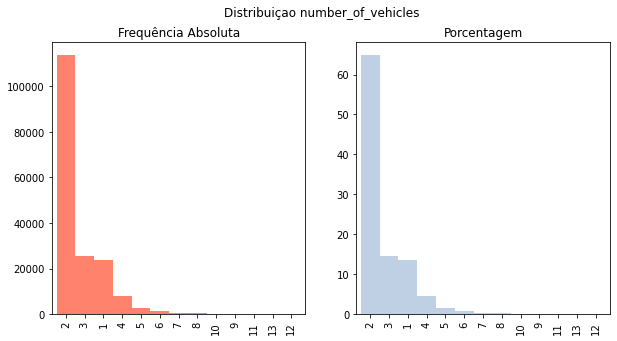

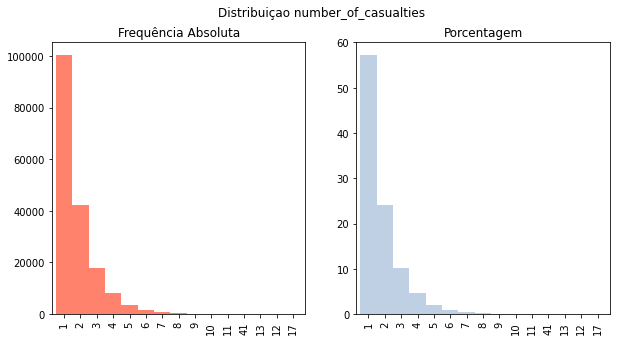

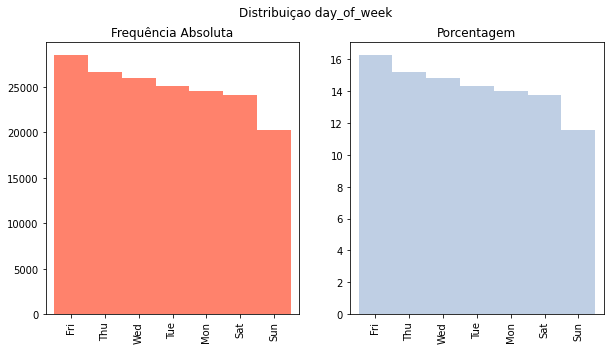

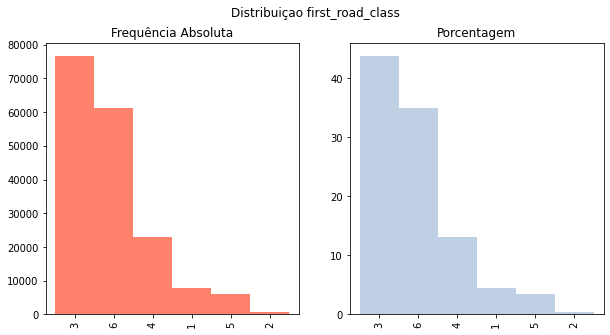

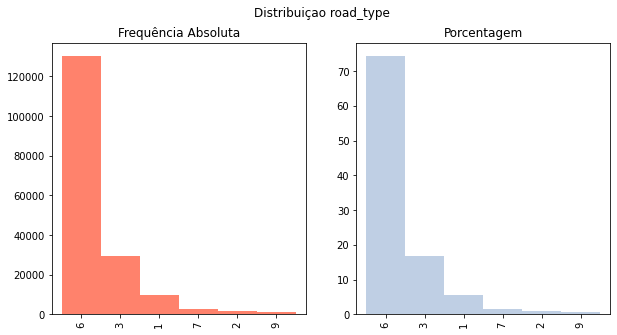

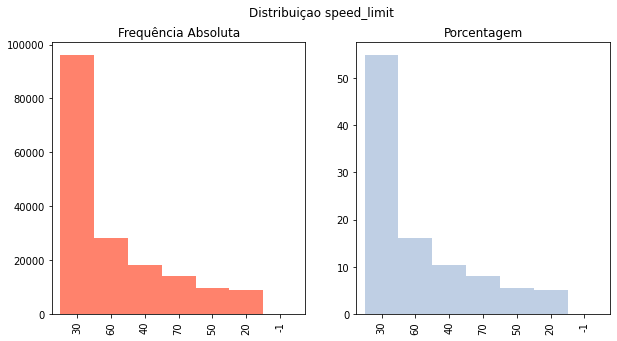

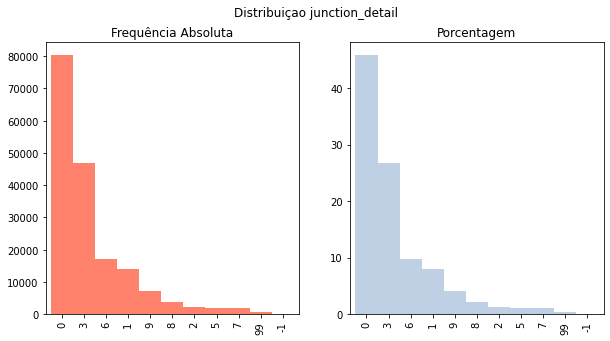

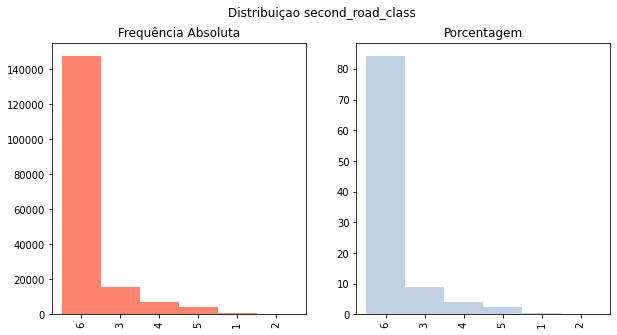

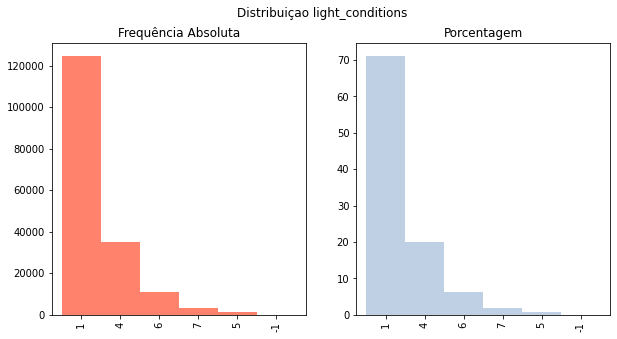

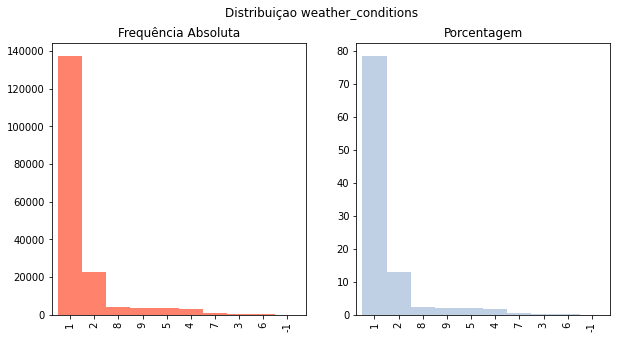

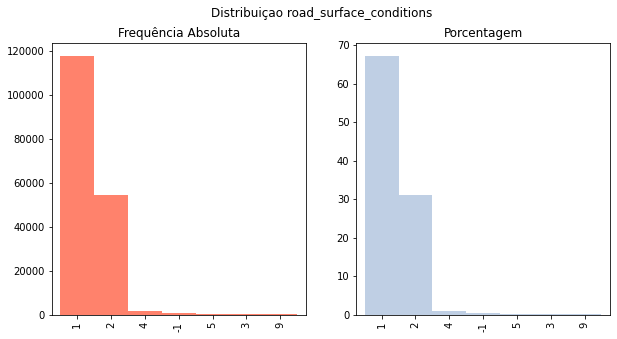

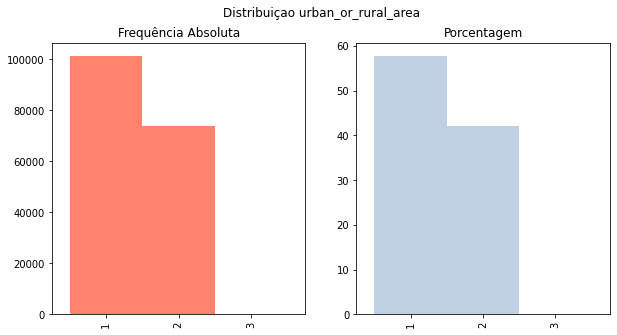

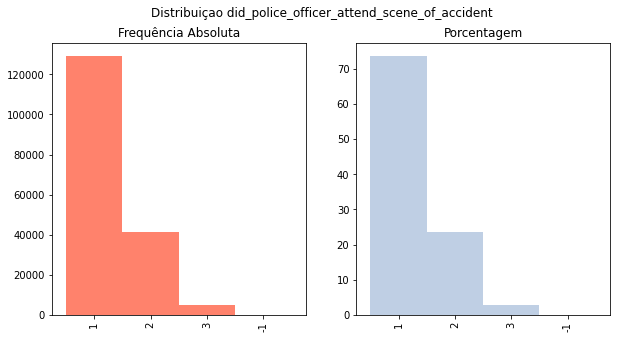

In [30]:
# Repetindo o for para plotar os gráficos dos incident_other
# as colunas são as mesmas...

categorical = ['accident_severity', 'number_of_vehicles', 'number_of_casualties',
       'day_of_week', 'first_road_class', 'road_type', 'speed_limit', 'junction_detail',
       'second_road_class', 'light_conditions', 'weather_conditions', 'road_surface_conditions',
        'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident']

for x in categorical:
    frequencia = UK_incident_other[x].value_counts()
    percentual = UK_incident_other[x].value_counts(normalize=True) * 100

    freq_accident = pd.DataFrame({'Frequência': frequencia, 'Porcentagem': percentual})
    
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    fig. suptitle('Distribuiçao'+' '+ x)
    axes[0].set_title('Frequência Absoluta')
    axes[1].set_title('Porcentagem')
    freq_accident['Frequência'].plot.bar(width=1, alpha=0.8, color='tomato', ax=axes[0])
    freq_accident['Porcentagem'].plot.bar(width=1, alpha=0.8, color='lightsteelblue', ax=axes[1])
    plt.show

###**Agrupando por Dia da Semana**

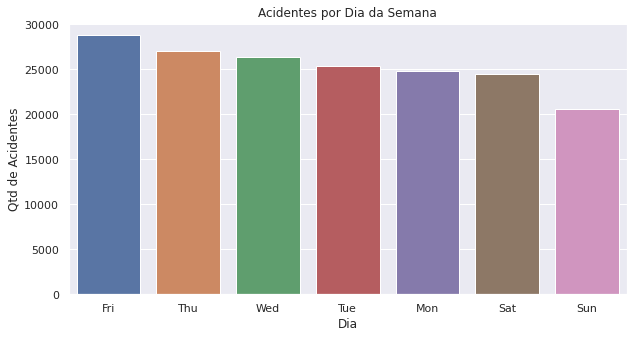

In [31]:
#  Acidentes TODOS através de gráfico

sns.set(rc={'figure.figsize':(10,5)})

sns.set_theme(style='darkgrid')
sns.countplot(x=UK_merge.day_of_week, data=UK_merge,
            order = UK_merge.day_of_week.value_counts().index)
plt.title('Acidentes por Dia da Semana')
plt.xlabel('Dia')
plt.ylabel('Qtd de Acidentes')
plt.show()

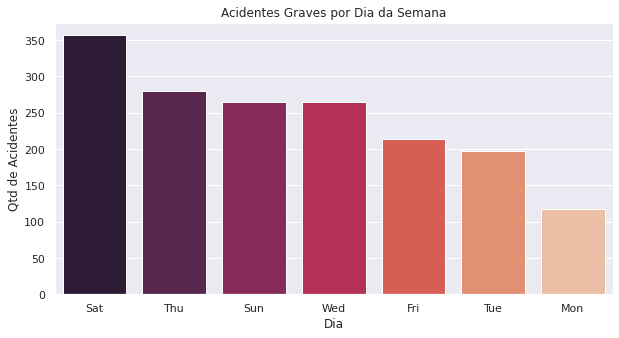

In [32]:
#  Acidentes graves através de gráfico

sns.set(rc={'figure.figsize':(10,5)})

sns.set_theme(style='darkgrid')
sns.countplot(x=UK_incident_major.day_of_week, data=UK_incident_major, 
              order = UK_incident_major.day_of_week.value_counts().index, palette='rocket')
plt.title('Acidentes Graves por Dia da Semana')
plt.xlabel('Dia')
plt.ylabel('Qtd de Acidentes')
plt.show()

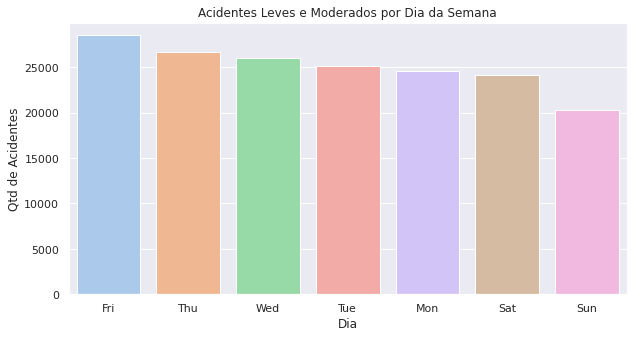

In [33]:
#  Acidentes outros por dia da semana, através de gráfico

sns.set(rc={'figure.figsize':(10,5)})

sns.set_theme(style="darkgrid")
sns.countplot(x=UK_incident_other.day_of_week, data=UK_incident_other,
              order = UK_incident_other.day_of_week.value_counts().index, palette='pastel')
plt.title('Acidentes Leves e Moderados por Dia da Semana')
plt.xlabel('Dia')
plt.ylabel('Qtd de Acidentes')
plt.show()

###**Agrupando por Faixas de Horário**

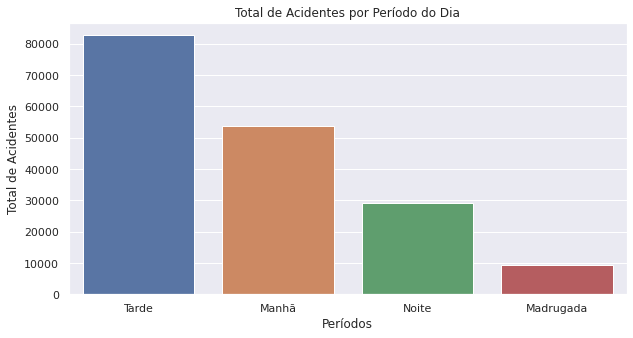

In [34]:
# Criando bins (compartimentos) para horário do dia

bins = [0, 6, 12, 18, 24]
labels = ['Madrugada', 'Manhã', 'Tarde', 'Noite']

UK_merge['hour_bin'] = pd.cut(UK_merge['time_stamp'].dt.hour, bins=bins, labels=labels)

# Plotando os resultados dos bins

sns.countplot(x=UK_merge.hour_bin, data = UK_merge, 
              order = UK_merge.hour_bin.value_counts().index)
plt.title('Total de Acidentes por Período do Dia')
plt.xlabel('Períodos')
plt.ylabel('Total de Acidentes')
plt.show()

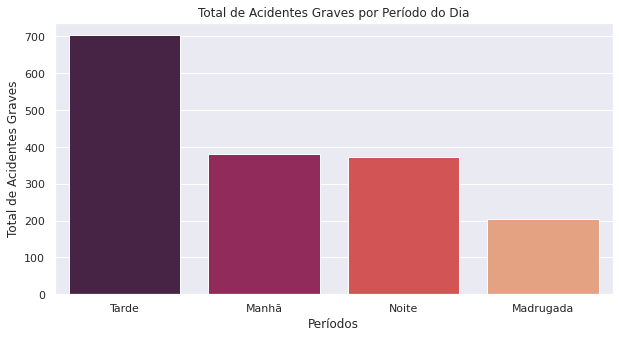

In [35]:
# Criando mesmos bins para o dataframe de acidentes graves

bins = [0, 6, 12, 18, 24]
labels = ['Madrugada', 'Manhã', 'Tarde', 'Noite']

UK_incident_major['hour_bin'] = pd.cut(UK_incident_major['time_stamp'].dt.hour, bins=bins, labels=labels)

# Plotando os resultados dos bins

sns.countplot(x = UK_incident_major.hour_bin, data = UK_incident_major, 
              order = UK_incident_major.hour_bin.value_counts().index, palette='rocket')
plt.title('Total de Acidentes Graves por Período do Dia')
plt.xlabel('Períodos')
plt.ylabel('Total de Acidentes Graves')
plt.show()

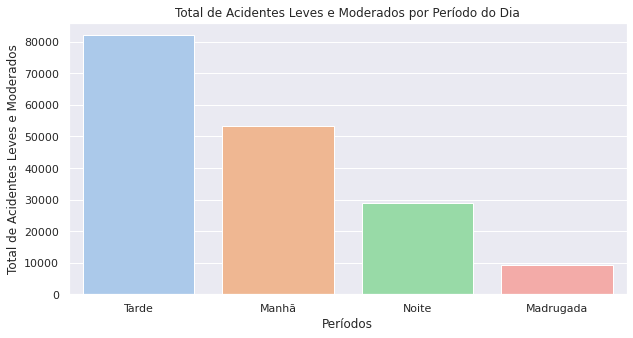

In [36]:
# E o mesmo processo para o dataframe de acidentes outros
# Assim podemos comparar como os valores ficam diferentes dependendo de cada tipo de acidente

bins = [0, 6, 12, 18, 24]
labels = ['Madrugada', 'Manhã', 'Tarde', 'Noite']

UK_incident_other['hour_bin'] = pd.cut(UK_incident_other['time_stamp'].dt.hour, bins=bins, labels=labels)

# Plotando os resultados dos bins

sns.countplot(x = UK_incident_other.hour_bin, data = UK_incident_other, 
              order = UK_incident_other.hour_bin.value_counts().index, palette='pastel')
plt.title('Total de Acidentes Leves e Moderados por Período do Dia')
plt.xlabel('Períodos')
plt.ylabel('Total de Acidentes Leves e Moderados')
plt.show()

###**Agrupando por Hora do Dia**

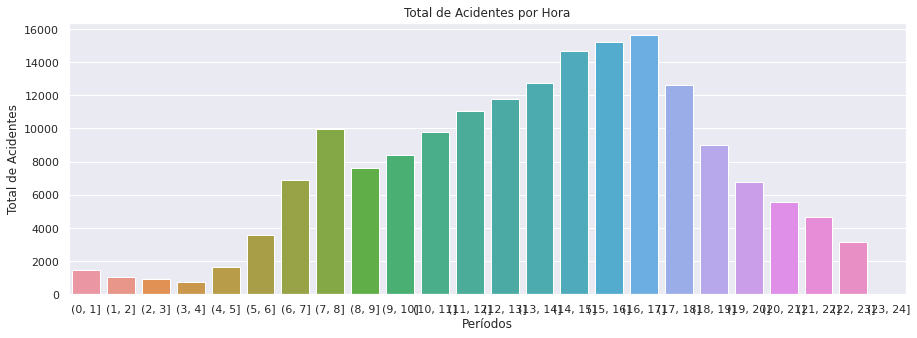

In [37]:
# Para entender mais a fundo, vou criar um novo fatiamento por hora do dia

bins = list(range(0,25))

UK_merge['hour_by_hour_bin'] = pd.cut(UK_merge['time_stamp'].dt.hour, bins=bins)

# Plotando os resultados dos bins

sns.set(rc = {'figure.figsize':(15,5)})
sns.countplot(x = UK_merge.hour_by_hour_bin, data = UK_merge)
plt.title('Total de Acidentes por Hora')
plt.xlabel('Períodos')
plt.ylabel('Total de Acidentes')
plt.show()

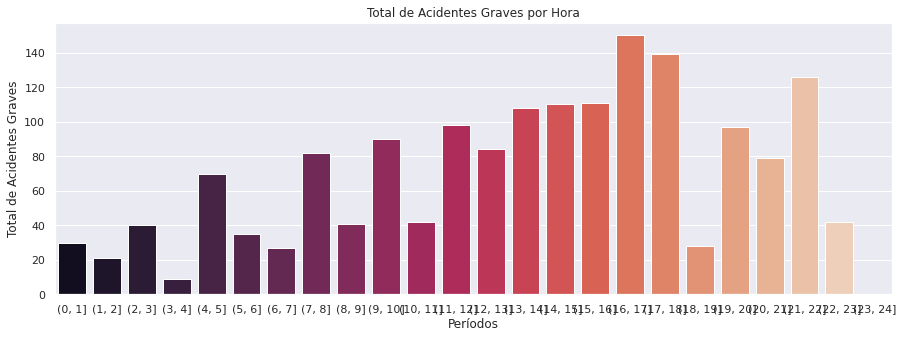

In [38]:
# Mesmo Fatiamento para Acidentes Graves

bins = list(range(0,25))

UK_incident_major['hour_by_hour_bin'] = pd.cut(UK_incident_major['time_stamp'].dt.hour, bins=bins)

# Plotando os resultados dos bins

sns.set(rc = {'figure.figsize':(15,5)})
sns.countplot(x = UK_incident_major.hour_by_hour_bin, data = UK_incident_major, palette='rocket')
plt.title('Total de Acidentes Graves por Hora')
plt.xlabel('Períodos')
plt.ylabel('Total de Acidentes Graves')
plt.show()

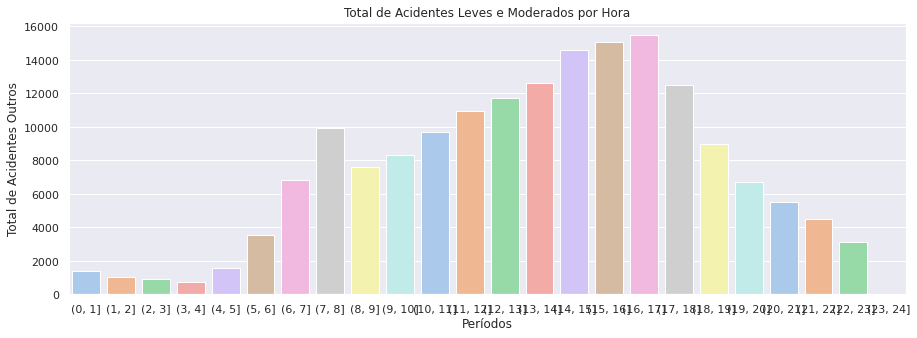

In [39]:
# Mesmo Fatiamento para Acidentes Leves e Moderados

bins = list(range(0,25))

UK_incident_other['hour_by_hour_bin'] = pd.cut(UK_incident_other['time_stamp'].dt.hour, bins=bins)

# Plotando os resultados dos bins

sns.set(rc = {'figure.figsize':(15,5)})
sns.countplot(x = UK_incident_other.hour_by_hour_bin, data = UK_incident_other, palette='pastel')
plt.title('Total de Acidentes Leves e Moderados por Hora')
plt.xlabel('Períodos')
plt.ylabel('Total de Acidentes Outros')
plt.show()

In [40]:
# Vou olhar comparativamente, agora, para algumas features entre o grupo de acidentes graves e 
# o outro grupo de acidentes leves e moderados

feat_comparative = ['number_of_vehicles','day_of_week','road_type', 'speed_limit', 'junction_detail',
        'light_conditions', 'weather_conditions', 'road_surface_conditions', 
        'special_conditions_at_site', 'urban_or_rural_area', 'major_incident', 'hour_bin']


n_absoluto = UK_merge['major_incident'].value_counts()
percentual = UK_merge['major_incident'].value_counts(normalize=True) * 100

print (n_absoluto, percentual)

0    175332
1      1692
Name: major_incident, dtype: int64 0    99.044197
1     0.955803
Name: major_incident, dtype: float64


**99. 76%**, ou 84.940 casos são acidentes considerados leves e moderados

**0.23%** apenas, ou 200 casos são acidentes considerados graves

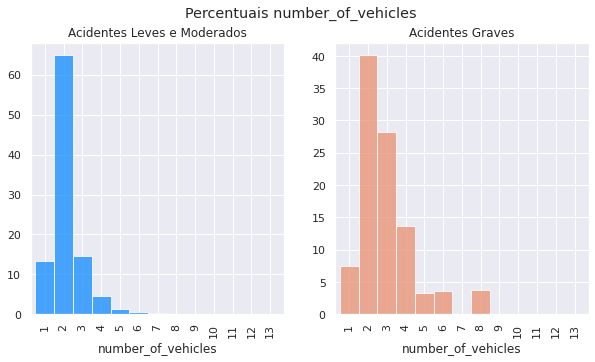

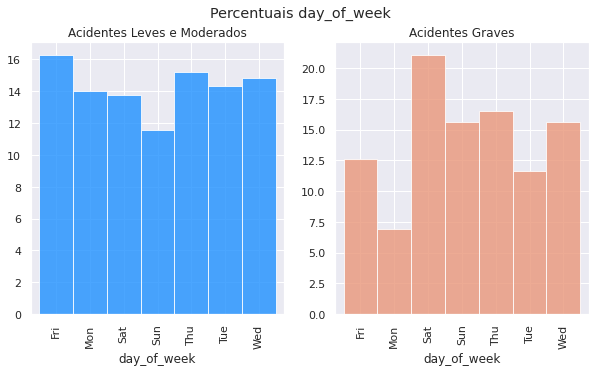

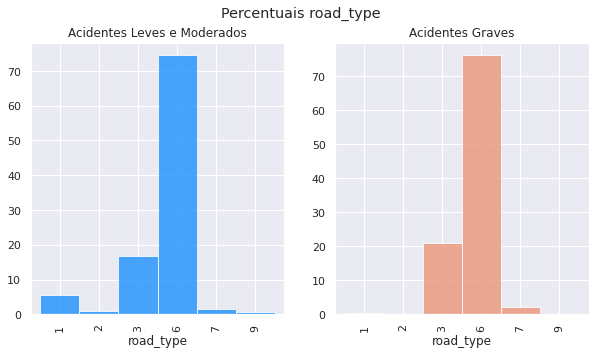

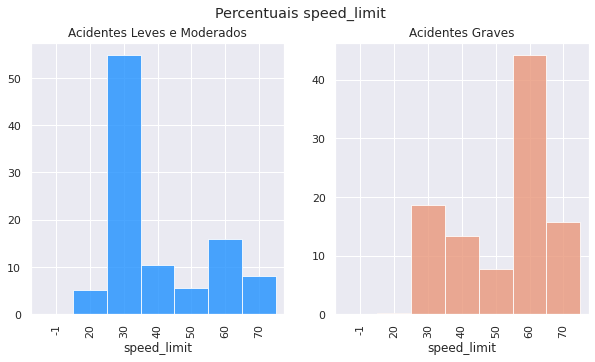

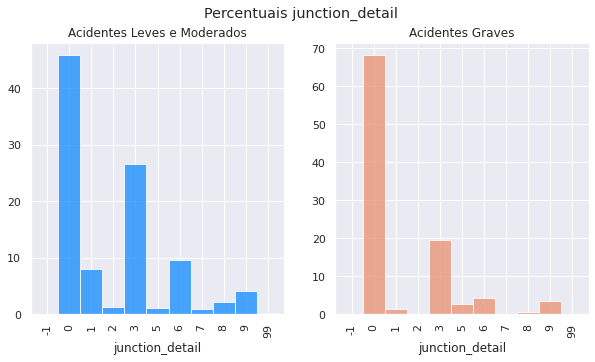

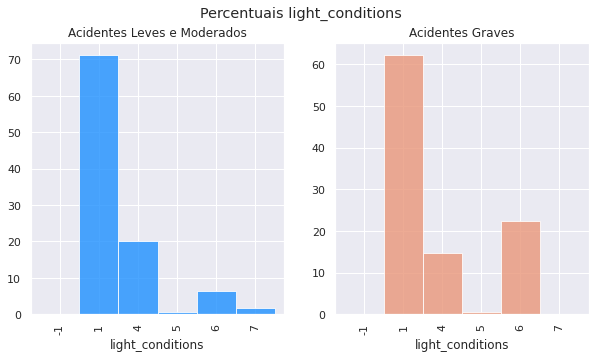

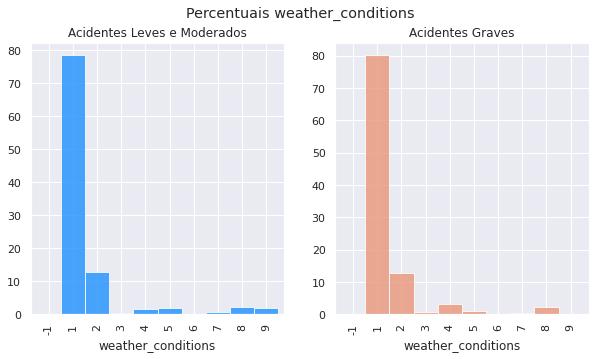

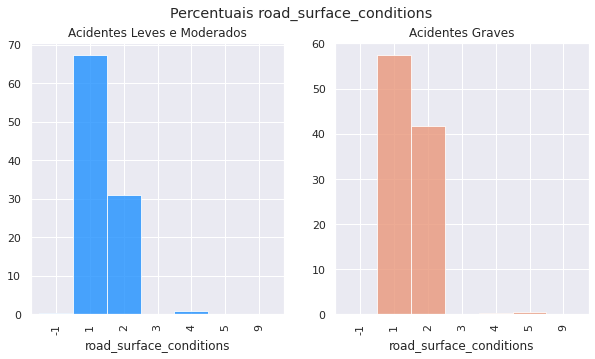

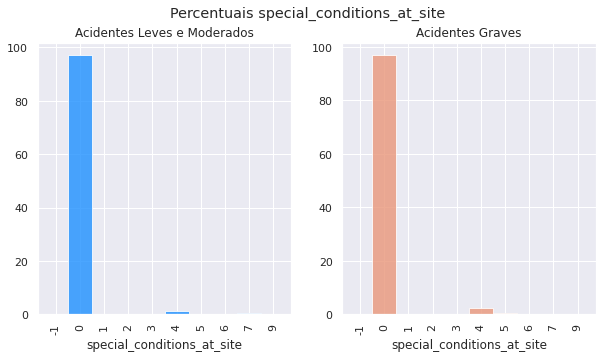

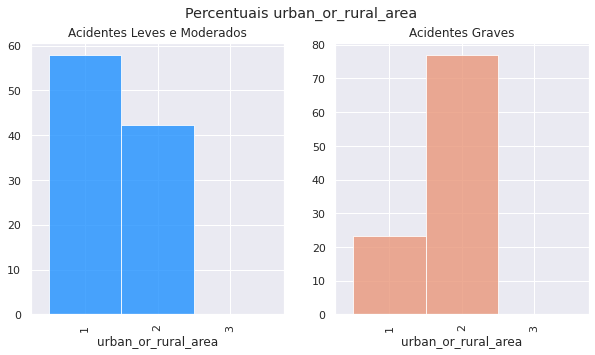

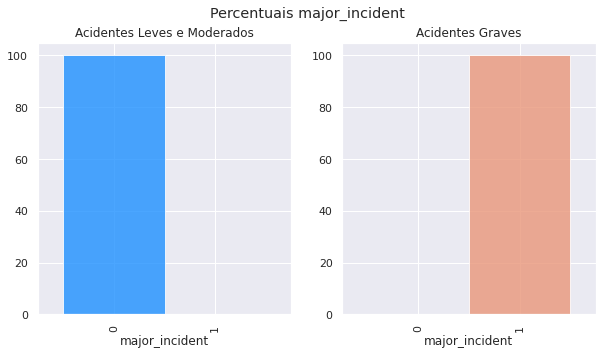

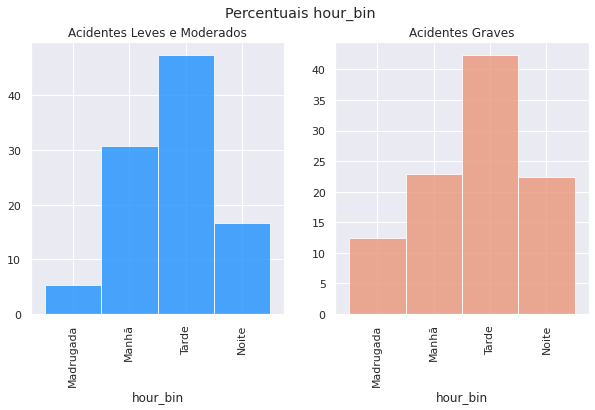

In [41]:
# Comparando os % de acidentes leves e moderados com acidentes graves

for col in feat_comparative:
    total_g_0 = UK_merge.loc[UK_merge['major_incident']==0].groupby(col)['major_incident'].count()
    total_g_1 = UK_merge.loc[UK_merge['major_incident']==1].groupby(col)['major_incident'].count()

    percent_g_0 = round(total_g_0/total_g_0.sum()*100,2)
    percent_g_1 = round(total_g_1/total_g_1.sum()*100,2)

    df_grupos = pd.DataFrame({'Grupo_0': percent_g_0, 'Grupo_1': percent_g_1})

    fig, axes = plt.subplots(1,2, figsize=(10,5))
    fig. suptitle('Percentuais'+' '+ col)
    axes[0].set_title('Acidentes Leves e Moderados')
    axes[1].set_title('Acidentes Graves')
    df_grupos['Grupo_0'].plot.bar(width=1, alpha=0.8, color='dodgerblue', ax=axes[0])
    df_grupos['Grupo_1'].plot.bar(width=1, alpha=0.8, color='darksalmon', ax=axes[1])
    plt.show

**Legendas das features**

Road Type 1: Roundabout 2: One way street 3: Dual carriageway 6: Single carriageway 7: Slip road

Junction Detail 0: Not at junction or within 20 metres 1: Roundabout 2: Mini-roundabout 3: T or staggered junction 5: Slip road 6: Crossroads 7: More than 4 arms (not roundabout) 8: Private drive or entrance 9: Other junction

Light Conditions 1: Daylight 4: Darkness - lights lit 5: Darkness - lights unlit 6: Darkness - no lighting 7: Darkness - lighting unknown

Weather Conditions 1: Fine no high winds 2: Raining no high winds 3: Snowing no high winds 4: Fine + high winds 5: Raining + high winds 6: Snowing + high winds 7: Fog or mist 8: Other

Road Surface Conditions 1: Dry 2: Wet or damp 3: Snow 4: Frost or ice 5: Flood over 3cm

Urban / Rural Area 1: Urban 2: Rural

##**Comparação entre os acidentes graves e os outros**

1 - 60% dos acidentes graves possuem 3 vítimas, seguidos por 20% com 4 vítimas: Acidentes graves geram notadamente mais vítimas.

2 - Mais de 25% dos acidentes graves ocorrem aos sábados, seguido por quinta-feira com pouco mais de 15%

3- Mais de 45% dos acidentes graves ocorrem em áreas com limite de velocidade até 60mph. Acidentes leves e moderados acontecem mais em áreas com limite de velocidade baixo, enquanto os acidentes graves majoritariamente acontecem em áreas com limites de velocidade mais altos.

4 - Os acidentes leves correspondem a quase 80% dos registros, enquanto acidentes moderados correspondem a 20%. Apenas 0,02% são considerados graves.

5 - Em termos gerais, acidentes leves e moderados (outros) envolvem um ou dois veículos, 1 ou 2 vítimas, em vias urbanas com limite de velocidade de até 30mph e ocorrem principalmente às sextas-feiras e dias da semana.
Já acidentes graves ocorrem em vias urbanas com até 60mph, principalmente aos sábados, envolvem 3 ou mais vítimas e dois ou mais veículos.

6 - Os acidentes leves e moderados ocorrem com uma variação pequena ao longo dos dias da semana. O dia em que há mais registros de acidentes deste tipo é a sexta (16%) e o dia com menor registro de acidentes é o domingo (11%).
No caso dos acidentes graves a variação é bem maior. O dia em que há mais acidentes é o sábado, com quase 25% dos casos, enquanto o dia com menos acidentes graves é a segunda feira, com pouco mais de 5%.

7 - Quando analisamos o período do dia, percebemos que tanto para os acidentes leves e moderados quanto para os graves, o horário em que predominam as ocorrências é o período da tarde (45% e 40% respectivamente). O segundo período com mais acidentes leves e moderados é a manhã (30%), enquanto os acidentes graves ocorrem mais no período noturno e na madrugada (quase 25% e 15% respectivamente).

8 - Quando olhamos para a quantidade de acidentes nas zonas rurais e urbanas, fica evidente a predominância dos acidentes leves e moderados nas zonas urbanas (65% em zonas urbanas e 35% em zonas rurais).
Já nas zonas rurais predominam os acidentes graves, com 70% dos registros, contra 25% das ocorrências em àreas urbanas.

9 - Ao analisarmos a variável road_surface_conditions (condições da pavimentação da via), podemos perceber que os acidentes graves aumentam em 10 pontos percentuais quando a condição da pavimentação é 2 (wet or damp, molhada). A maioria dos acidentes acontece com pista seca, 70% e 60% de acidentes leves e moderados, respectivamente. Quando a pavimentação está molhada os percentuais são 29% e 42%, ou seja, acidentes graves acontecem mais em pista molhada.

10 - A variável weather_conditions possui uma distribuição quase idêntica entre acidentes leves e acidentes graves, com um leve incremento nos percentuais de acidentes graves quando o tempo está com ventos mais intensos.

11 - Quando não há iluminação pública nas vias, os acidentes graves tendem a acontecer bem mais (aprox. 7% a 22%), em relação a outras condições de iluminação, a distribuição permanece semelhante.

12 - A maioria dos acidentes, tanto os leves quanto os graves, ocorre em trechos de vias sem junções em até 20 metros (aprox. 45% e 70%). Acidentes leves ocorrem mais em rotatórias (8%), cruzamentos (10%) e, principalmente, junções em T (quase 30%), enquanto acidentes graves ocorrem principalmente em trechos sem junção (70%) e em trechos com junção em T (18%).

13 - Acidentes acontecem principalmente em vias de mão dupla sem separação, em torno de 80% das ocorrências, tanto as leves quanto as graves.

##**Aprendizado Não Supervisionado**

###**Tratamento dos Dados - Dummificação**

Vou utlizar uma análise com clusterização para tentar entender alguns grupos de acidentes mais comuns e quais suas características mais importantes.

Irei aplicar o algoritmo KMeans e avaliar o resultado.

Mas antes de aplicar o algoritmo, é preciso avaliar a estrutura dos dados e fazer algum pré-processamento para que o algoritmo possa clusterizar os dados com maior eficácia.

In [ ]:
# Dummificação ou binarização dos dados
# Transformar colunas com dados categóricos em novas colunas com dados binários
# vou usar o df_accidents e a lista de colunas categóricas

#df_accidents_dummy = pd.get_dummies(data=df_accidents, 
 #   columns = categorical,
  #  prefix = categorical
    )


#df_accidents_dummy.head()

In [ ]:
# Esta forma automática de dummificação não ficou boa, pois há colunas com muitos valores
# resulta num dataset dummificado (com 0s e 1s) com muitas colunas repetidas, muito extenso

# vou olhar alguns casos separadamente, por exemplo: number of casualties

#sorted(df_accidents['number_of_casualties'].unique())

In [ ]:
#df_accidents['number_of_casualties'].value_counts() /
#  df_accidents['number_of_casualties'].value_counts().sum()

In [ ]:
#sorted(df_accidents['road_type'].unique())

In [ ]:
#percent_nulos = df_accidents.isnull().sum() * 100 / len(df_accidents)
#percent_nulos